In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
def generate_non_transit_curve(num_points, noise_level):
    """
    Generates a curve with no transit effect, only Gaussian noise.
    Parameters:
    - num_points (int): Number of points in the curve.
    - noise_level (float): Level of Gaussian noise to add to the curve.
    """
    flux = np.ones(num_points)
    flux += np.random.normal(0, noise_level, num_points)
    return flux

In [3]:
def synthetic_data_exo(num_samples=5000, num_points=3000):
    """
    Generates an unbalanced dataset
    Parameters:
    - num_samples : Total number of samples to generate.
    - num_points (int): Number of points in each curve.
    """
    data = []
    labels = []  # 1 for exoplanet, 0 for non-exoplanet
    num_exoplanet_samples=int(0.005*num_samples) #assuming only 0.5% samples are exoplanet for generating unbalanced
    
    # Parameters for diversity in exoplanet samples
    star_radii_range = [0.8, 1.2] #Star radius in solar unit
    planet_radii_range = [0.03, 0.15] #Planet radius in jupiter unit
    orbital_periods_range = [20, 120] #Orbit periods days
    transit_duration_factors_range = [0.05, 0.15] #transition duration factor
    noise_levels_range = [0.0005, 0.001] #gaussian noise
    outlier_chance = 0.005 #outlier threshold

    # Generate exoplanet samples
    for _ in range(num_exoplanet_samples):
        #Using random value from each parameter range to generate the data
        star_radius = np.random.uniform(*star_radii_range)
        num_planets = np.random.randint(1, 6)  # Random number of planets (1 to 5)
        # Randomly generate planetary parameters
        planet_radii = [np.random.uniform(*planet_radii_range) for _ in range(num_planets)]
        orbital_periods = sorted([np.random.uniform(*orbital_periods_range) for _ in range(num_planets)])
        transit_duration_factors = [np.random.uniform(*transit_duration_factors_range) for _ in range(num_planets)]
        noise_level = np.random.uniform(*noise_levels_range)
        flux = np.ones(num_points) #empty flux data

        for i, (planet_radius, orbital_period, transit_duration_factor) in enumerate(zip(planet_radii, orbital_periods, transit_duration_factors)):
            transit_depth = (planet_radius / star_radius) ** 2   #transit depth calculted (R_p/R_s)^2
            transit_duration = orbital_period * transit_duration_factor  #refer blog for these formulas and other advance book
            transit_width = int(num_points * (transit_duration / max(orbital_periods)))
            phase_shift = i * num_points // (num_planets + 1)
            
            midpoint = phase_shift + transit_width // 2
            start = max(0, midpoint - transit_width // 2)
            end = min(num_points, midpoint + transit_width // 2)
            limb=random.choice([True, False]) #Randomly determining if limb darkening occurs with quadratic function
            if limb==True:
                u1,u2=(np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3))
            else:
                u1,u2=(0,0)
            ingress_egress_width = transit_width // 2 # ingress engress width and smoothing the transition 
            for j in range(ingress_egress_width): 
                phase = np.pi * (i - midpoint) / transit_width  # Phase angle for limb darkening
                limb_darkening_factor = 1 - u1 * (1 - np.cos(phase)) - u2 * (1 - np.cos(phase))**2
                angle = np.pi * j / ingress_egress_width
                #flux when exoplanet is present in line of sight
                flux[start + j] -= transit_depth * (1 - np.cos(angle)) / 2 * limb_darkening_factor
                flux[end - j - 1] -= transit_depth * (1 - np.cos(angle)) / 2 * limb_darkening_factor
            
            flux[start + ingress_egress_width:end - ingress_egress_width] -= transit_depth  #flux when exoplanet is absent in los 
        
        # Add Gaussian noise randomly
        flux += np.random.normal(0, noise_level, num_points)
        for i in range(num_points):
            if np.random.rand() < outlier_chance:
                flux[i] += np.random.normal(0, 0.005)  
                # Adding a larger noise spike as an outlier if random value is less than outlier chance treshold value to 
                #make it look like real data having outliers because of instrument artifacts, noise from enviroment,etc 

        data.append(flux)
        labels.append(1)  # Label exoplanet samples as 1

    # Generate non-exoplanet samples
    num_non_exoplanet_samples = num_samples - num_exoplanet_samples
    for _ in range(num_non_exoplanet_samples):
        noise_level = np.random.uniform(*noise_levels_range) #random noise
        curve = generate_non_transit_curve(num_points=num_points, noise_level=noise_level)
        for i in range(num_points):
            if np.random.rand() < outlier_chance:
                curve[i] += np.random.normal(0, 0.005)  # Adding a larger noise spike as an outlier for instrument, etc

        data.append(curve)
        labels.append(0)  # Label non-exoplanet samples as 0

    # Combine and randomly shuffle the dataset for non-homogenity
    combined = list(zip(data, labels))
    np.random.shuffle(combined)
    data, labels = zip(*combined)
    dataset = pd.DataFrame(data)

    # Convert to DataFrame
    dataset = pd.DataFrame(data)
    dataset['Label'] = labels

    return dataset

# Generate the unbalanced dataset with exoplanets and non-exoplanet data synthetic
dataset = synthetic_data_exo()



In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label
0,0.999724,0.999108,1.000839,1.000066,1.000220,0.999548,0.999336,0.998445,1.001325,1.000429,...,0.999270,0.999123,0.998802,1.000245,1.001066,0.998337,0.998637,1.000393,0.999797,0
1,1.000153,1.000537,0.998914,0.999334,1.000262,0.999145,1.000727,1.000456,1.000185,0.998631,...,0.999732,1.000042,0.999942,1.000395,1.000141,0.999641,1.001140,1.000068,0.999359,0
2,1.001683,1.001110,0.999891,0.998164,1.000508,0.997884,0.999204,0.997696,0.999938,0.999583,...,0.999846,0.998762,0.999869,1.000908,0.999649,1.000262,0.999306,1.001213,1.000422,0
3,1.000370,0.999712,0.999139,1.000572,0.998836,1.000734,0.999206,1.000642,0.999996,1.001683,...,0.999752,1.001465,0.999281,1.000801,0.999722,0.998986,0.999802,0.999915,0.999529,0
4,0.999471,0.999514,0.999400,1.001223,1.000278,1.000270,0.999677,0.999438,1.000730,0.998913,...,1.000448,1.000283,0.999690,1.000544,1.001270,0.998308,1.001464,1.000535,0.999369,0


In [5]:
print(dataset.shape)
# Check how many labels are there
dataset['Label'].unique()

(5000, 3001)


array([0, 1], dtype=int64)

In [6]:
dataset[dataset.isnull().any(axis = 1)]  # check for null values

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label


In [7]:
idx_lab2 = list(dataset[dataset['Label'] == 1].index)
print(f"Index list for label 1 star in the data:-\n{idx_lab2}\n")

Index list for label 1 star in the data:-
[113, 182, 288, 520, 547, 808, 910, 1772, 2010, 2672, 2817, 2848, 3094, 3173, 3190, 3573, 3685, 3687, 3733, 3847, 4099, 4453, 4526, 4533, 4643]



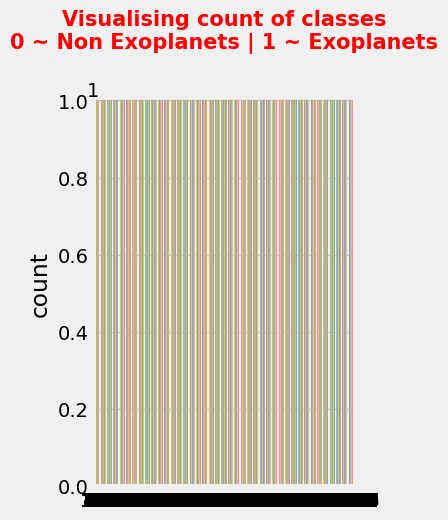

In [8]:
# Visualise these values using countplot
plt.figure(figsize = (3, 5))                                                   
ax = sns.countplot( data = dataset['Label'], palette = 'Set2')                    
ax.bar_label(ax.containers[0])
plt.title("Visualising count of classes\n0 ~ Non Exoplanets | 1 ~ Exoplanets\n", 
          fontsize = 15, color = 'red', weight = 'bold')
plt.show()

In [56]:
# Drop label column to plot only the flux values
plot_df = dataset.drop(['Label'], axis = 1)
col_names = list(plot_df.columns)

# Function to plot flux variation of star
def flux_plot(df, candidate, exo = True):
    color = 'b' if exo == True else 'm'
    plt.figure(figsize=(15, 5))
    plt.plot(col_names , df.iloc[candidate], linewidth = .5, color = color)
    title1, clr1 = f"Flux Variation of star {candidate} with Exoplanents", 'olive'
    title2, clr2 = f"Flux Variation of star {candidate} without Exoplanets", 'tab:red'
    plt.title(title1, color = clr1) if exo == True else plt.title(title2, color = clr2)
    plt.xlabel("Time")
    plt.ylabel("Flux Variation")

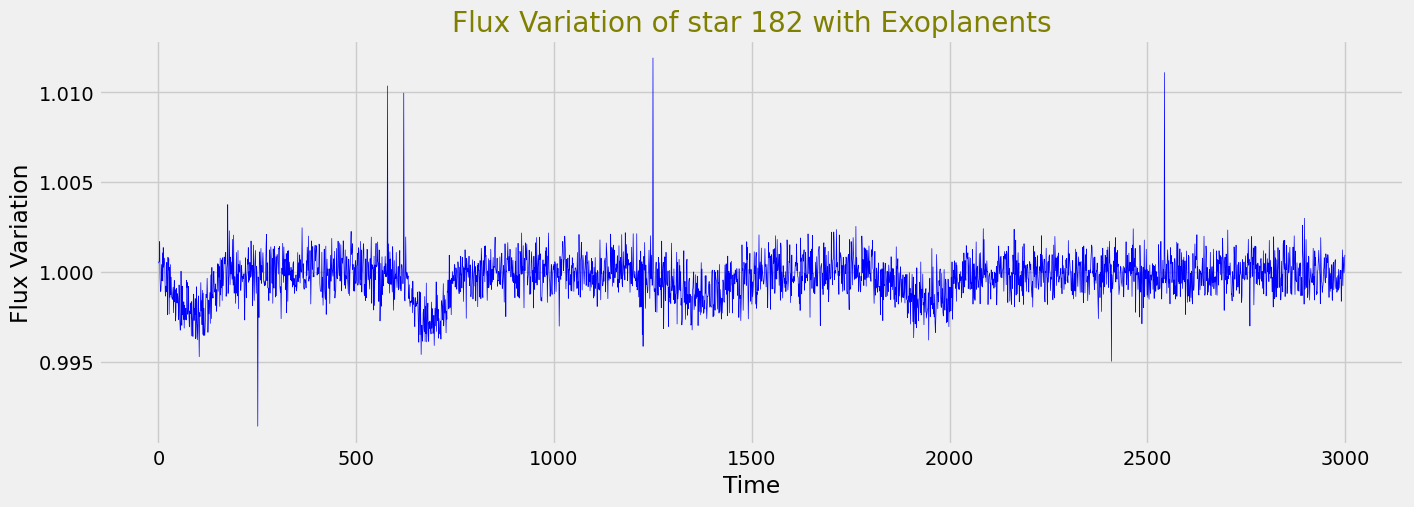

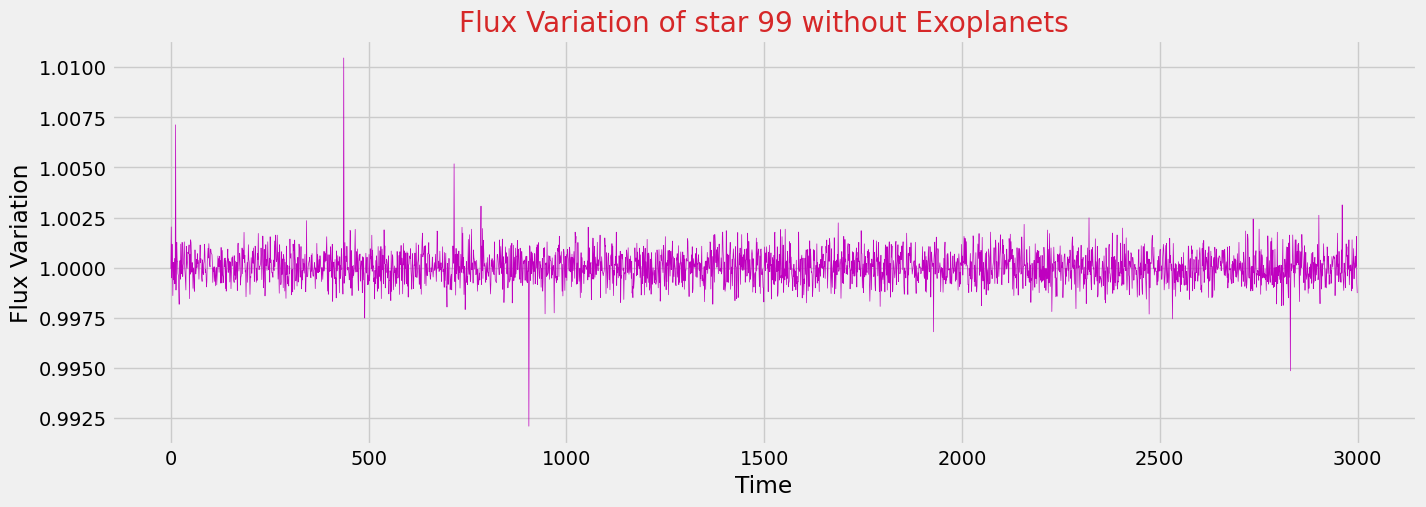

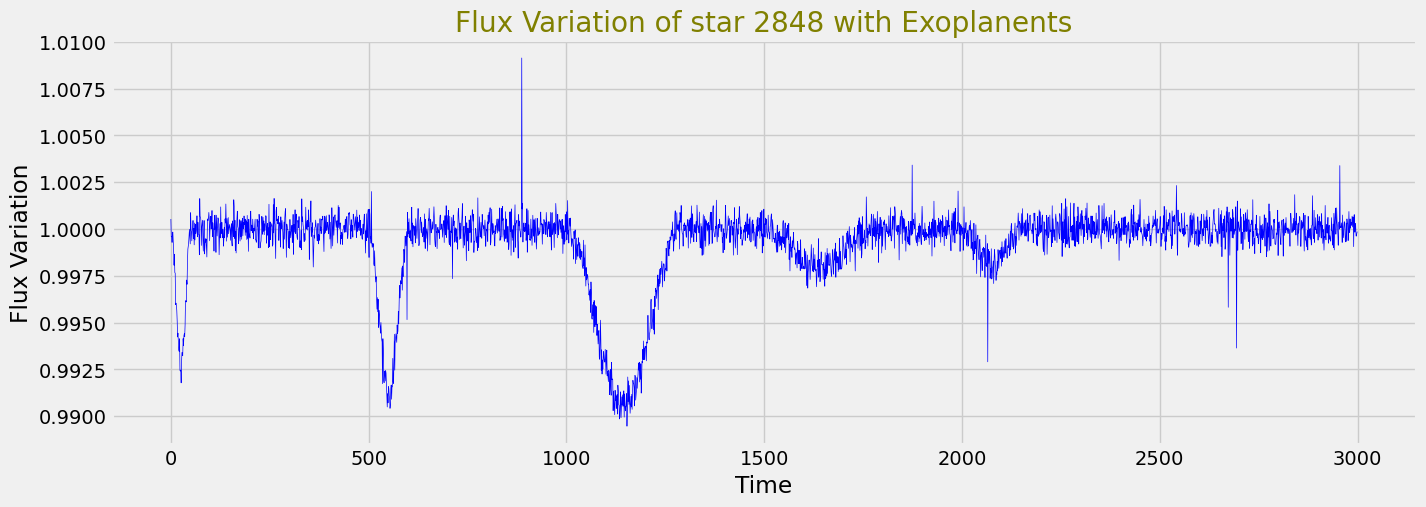

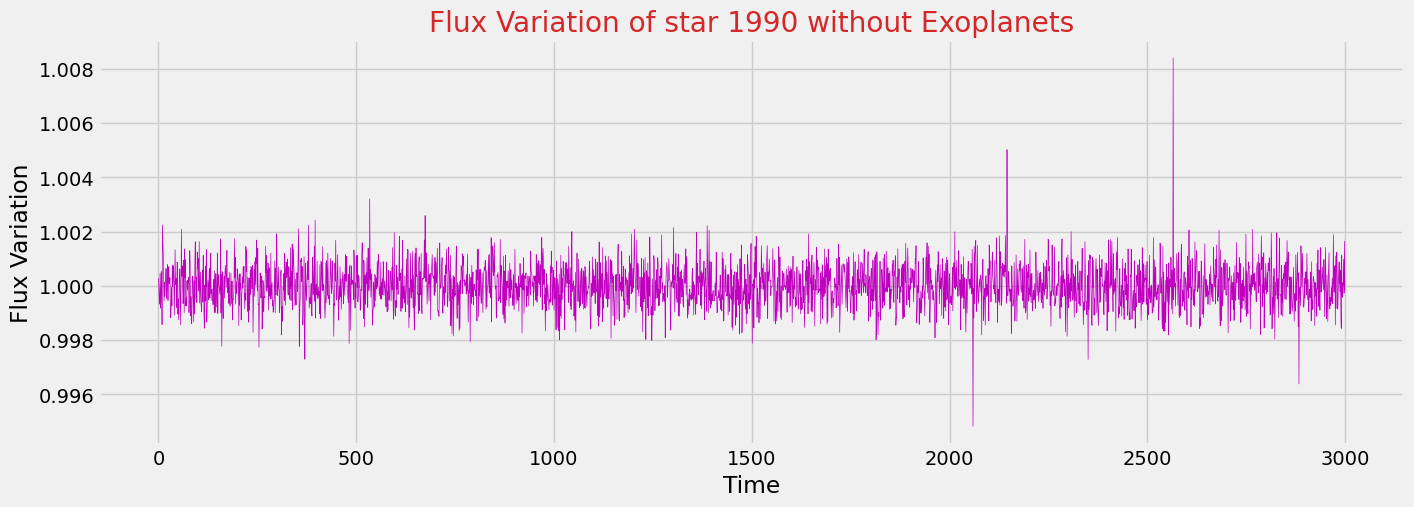

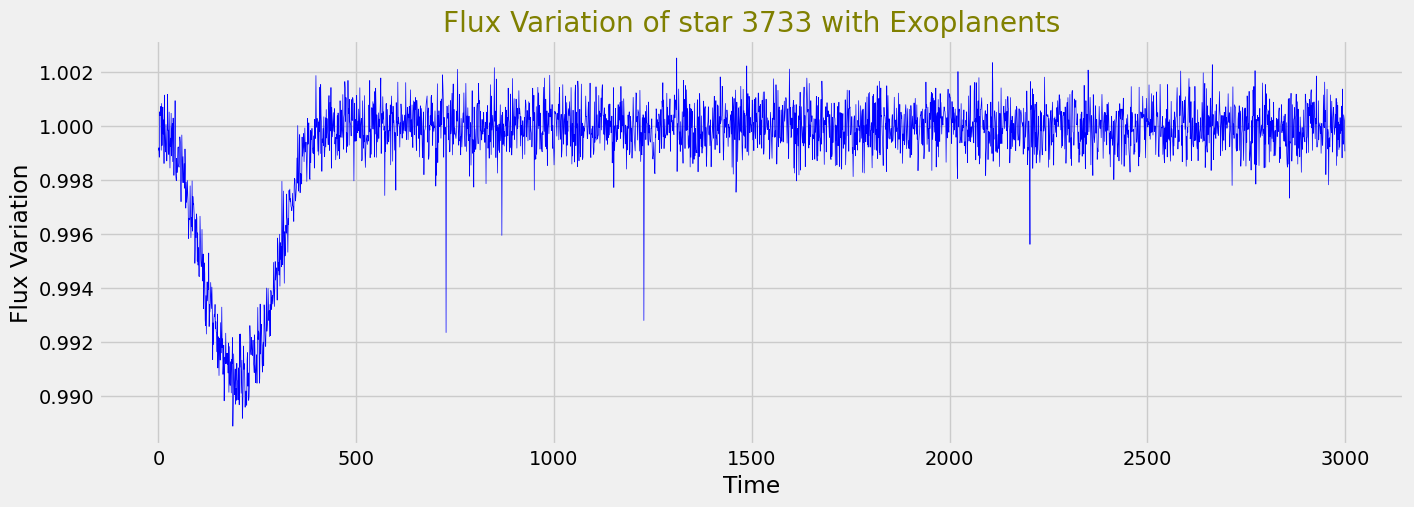

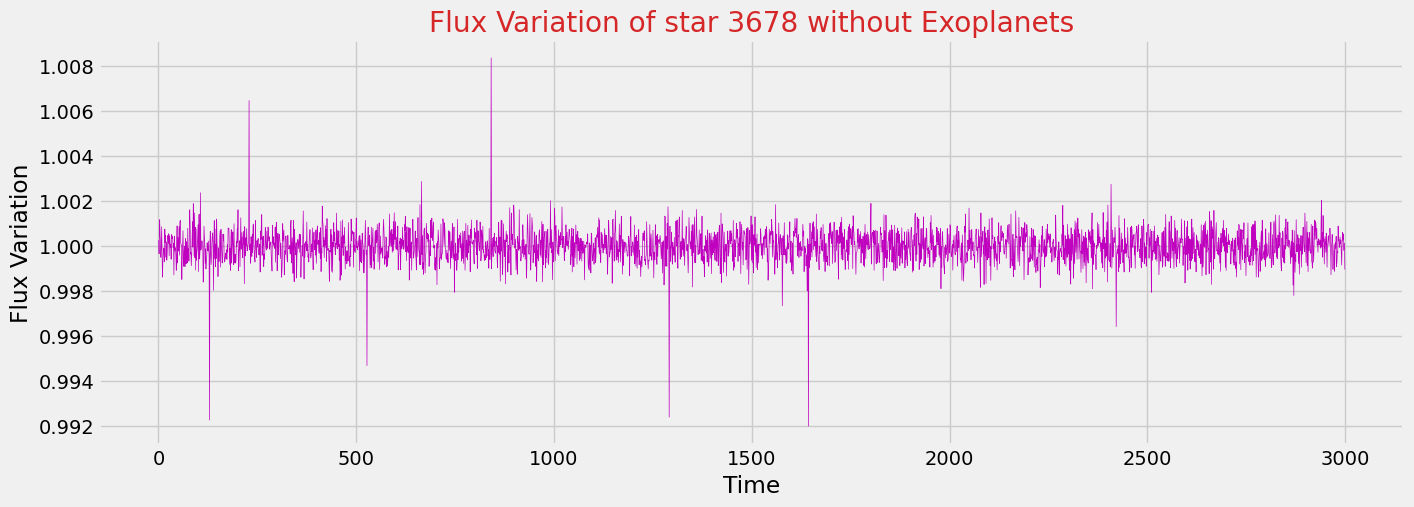

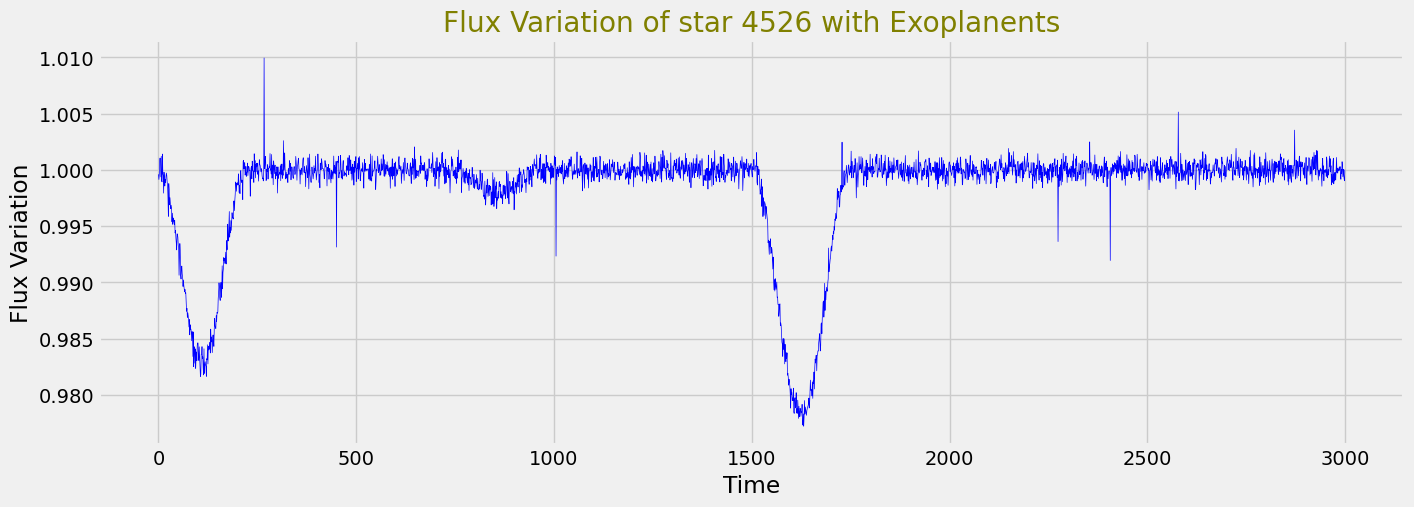

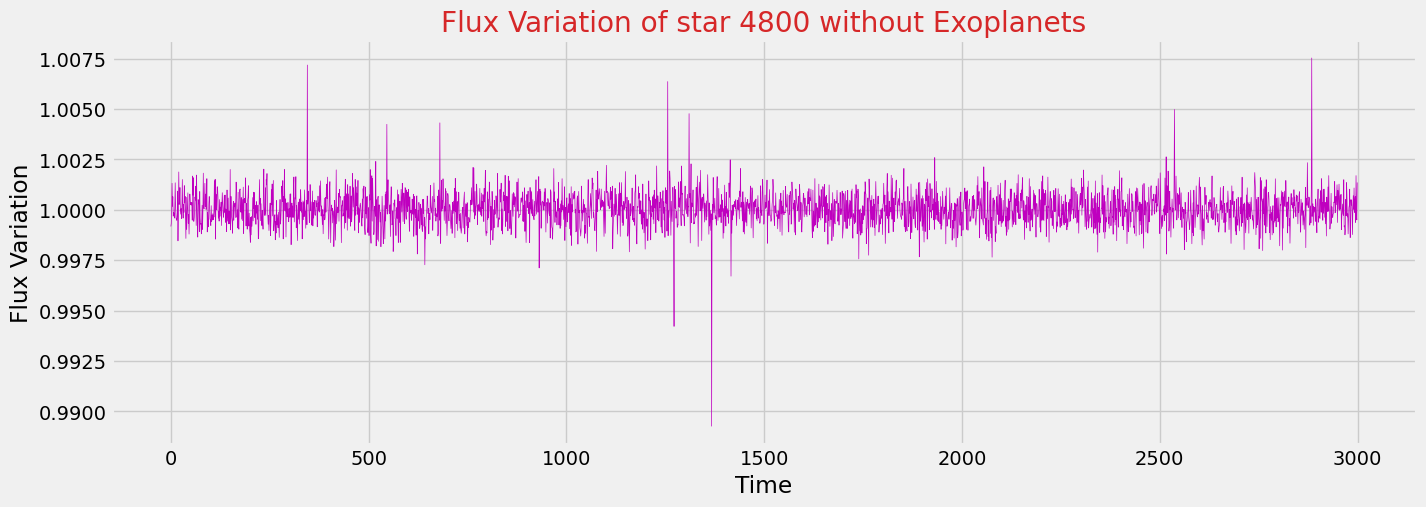

In [57]:
# Visulization of our synthetic light curves
exo, n_exo = [182, 2848, 3733, 4526], [99, 1990, 3678, 4800]

for candidate in range(len(exo)):
    flux_plot(plot_df, exo[candidate], exo = True)
    flux_plot(plot_df, n_exo[candidate], exo = False)

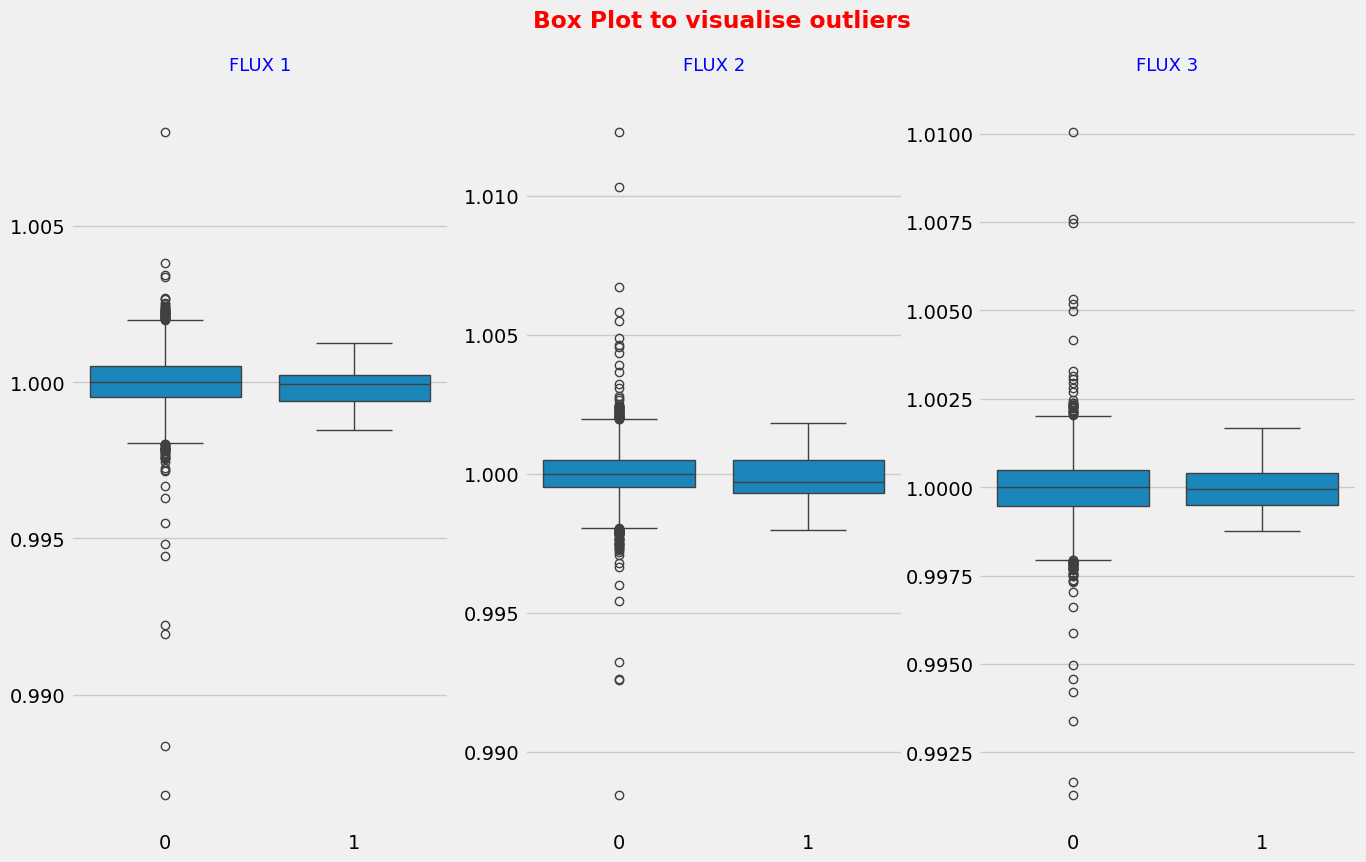

In [11]:
# Boxplot to visualise outliers
plt.figure(figsize = (20, 9))
plt.suptitle("Box Plot to visualise outliers", ha = 'right', color = 'red', weight = 'bold')
for i in range(1, 4):
    plt.subplot(1, 4, i)
    sns.boxplot(data=dataset, x='Label', y = i)
    plt.xlabel("")
    plt.ylabel("")
    plt.title("FLUX " + str(i) + "\n", color = 'b', fontsize = 13)

In [58]:
# Extract dependent and independent features
x = dataset.drop(['Label'], axis = 1)
y = dataset.Label
print(f"Take a look over ~\n\nX train array:-\n{x.values}\n\nY train array:-\n{y.values}")

Take a look over ~

X train array:-
[[0.99972439 0.99910784 1.00083947 ... 0.9986371  1.000393   0.99979666]
 [1.00015252 1.00053718 0.99891399 ... 1.00114015 1.00006768 0.99935882]
 [1.00168347 1.00110957 0.99989075 ... 0.99930553 1.00121255 1.00042206]
 ...
 [0.99970855 1.00035391 0.99961776 ... 0.9986925  0.9988284  1.00034505]
 [0.99940837 1.00149713 0.99975023 ... 0.99997532 0.99958037 1.00059435]
 [0.99957231 0.99902917 0.99962632 ... 0.99893539 1.00092758 0.99865802]]

Y train array:-
[0 0 0 ... 0 0 0]


In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
# Checking the minimum, mean and maxmum value after scaling
print("X_train after scaling ~\n")
print(f"Minimum:- {round(np.min(X_train_sc),2)}\nMean:- {round(np.mean(X_train_sc),2)}\nMax:- {round(np.max(X_train_sc), 2)}\n")
print("--------------------------------\n")
print("X_test after scaling ~\n")
print(f"Minimum:- {round(np.min(X_test_sc),2)}\nMean:- {round(np.mean(X_test_sc),2)}\nMax:- {round(np.max(X_test_sc), 2)}\n")

X_train after scaling ~

Minimum:- -28.17
Mean:- -0.0
Max:- 24.39

--------------------------------

X_test after scaling ~

Minimum:- -39.15
Mean:- -0.01
Max:- 23.49




Validation accuracy of KNN is 0.9946666666666667

-------------------------------------------------------

Classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1487
           1       1.00      0.38      0.56        13

    accuracy                           0.99      1500
   macro avg       1.00      0.69      0.78      1500
weighted avg       0.99      0.99      0.99      1500



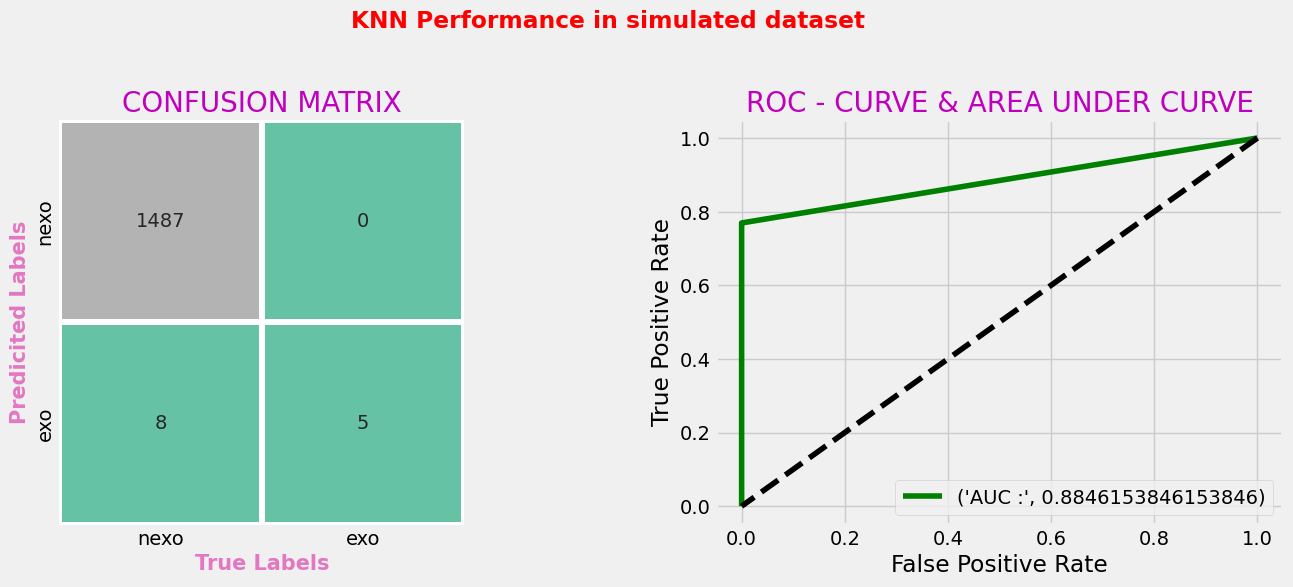

In [60]:
# Define a KNN Classifier
knn_classifier = KNC(n_neighbors=5,metric='minkowski',p=2)  
'''metric is to be by default minkowski for p = 2 to calculate the Eucledian distances'''
# Fit the model
knn_classifier.fit(X_train_sc, y_train)
# Predict
y_pred = knn_classifier.predict(X_test_sc)
# Results

print('\nValidation accuracy of KNN is', accuracy_score(y_test,y_pred))
print("\n-------------------------------------------------------")
print ("\nClassification report :\n",(classification_report(y_test,y_pred)))
#Confusion matrix
plt.figure(figsize=(15,11))
plt.subplots_adjust(wspace = 0.3)
plt.suptitle("KNN Performance in simulated dataset", color = 'r', weight = 'bold')
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'tab:pink')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'tab:pink')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'm')
#ROC curve and Area under the curve plotting
predicting_probabilites = knn_classifier.predict_proba(X_test_sc)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "g")
plt.plot([1,0],[1,0],"k--")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20, color = 'm')
plt.show()



# Here we see KNN Classifier does good classification. Now, we will supplement our synthetic data with obervational data from Kepler Space Telescope uploaded in this gdrive link(https://drive.google.com/drive/u/1/folders/1ctBU7naW0vvYuOYJIcYKQHTXOPaCPIyy)

In [15]:
# Load the labelled observational data
observational_data =  pd.read_csv('archive/keplerdata.csv')
# Load synthetic data
synthetic_data = dataset

In [16]:
observational_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [17]:
observational_data = observational_data.replace({'LABEL' : {1:0, 2:1}}) # 1 :exoplanet, 0: non exoplanet
observational_data

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,0,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,0,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,0,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [18]:
plot_df=observational_data.drop('LABEL', axis = 1) #drop label
label=observational_data['LABEL']
plot_df.columns = range(0, len(plot_df.columns) ) #change the column header to match the synthetic data column
plot_df

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,-11.88,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,384.34,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,238.51,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,6.29,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [19]:
simulated_data=synthetic_data.drop('Label', axis = 1)#drop simulated data label
simulated_data

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.999724,0.999108,1.000839,1.000066,1.000220,0.999548,0.999336,0.998445,1.001325,1.000429,...,0.998609,0.999270,0.999123,0.998802,1.000245,1.001066,0.998337,0.998637,1.000393,0.999797
1,1.000153,1.000537,0.998914,0.999334,1.000262,0.999145,1.000727,1.000456,1.000185,0.998631,...,1.001091,0.999732,1.000042,0.999942,1.000395,1.000141,0.999641,1.001140,1.000068,0.999359
2,1.001683,1.001110,0.999891,0.998164,1.000508,0.997884,0.999204,0.997696,0.999938,0.999583,...,0.998821,0.999846,0.998762,0.999869,1.000908,0.999649,1.000262,0.999306,1.001213,1.000422
3,1.000370,0.999712,0.999139,1.000572,0.998836,1.000734,0.999206,1.000642,0.999996,1.001683,...,0.998730,0.999752,1.001465,0.999281,1.000801,0.999722,0.998986,0.999802,0.999915,0.999529
4,0.999471,0.999514,0.999400,1.001223,1.000278,1.000270,0.999677,0.999438,1.000730,0.998913,...,1.000389,1.000448,1.000283,0.999690,1.000544,1.001270,0.998308,1.001464,1.000535,0.999369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.999365,1.000077,1.000309,0.999790,0.999806,1.001062,1.000119,1.001022,1.000830,0.999568,...,1.000629,0.998528,0.999032,0.999986,1.001593,1.000844,0.999889,1.000144,1.000408,0.999934
4996,1.000326,0.999895,0.999991,1.000925,1.000390,1.000813,1.001197,0.999328,0.998929,1.000959,...,0.998911,0.999945,1.001048,1.000854,1.000033,1.000780,0.999667,0.999150,0.999611,0.999633
4997,0.999709,1.000354,0.999618,0.999929,0.999366,1.000415,1.000547,0.999831,0.999770,0.999547,...,0.999412,1.000857,1.000023,0.999626,0.999963,0.999741,1.001002,0.998692,0.998828,1.000345
4998,0.999408,1.001497,0.999750,1.000531,1.000494,0.999903,0.999621,1.000481,1.001444,0.998992,...,0.999388,1.000625,1.001499,1.000092,1.000958,0.999147,1.000511,0.999975,0.999580,1.000594


In [20]:
# Number of columns to keep in observational data (based on simulated_data)
num_columns_to_keep = len(simulated_data.columns) # All column names from plot_df
all_columns = plot_df.columns# All column names from plot_df 
columns_to_drop = all_columns[num_columns_to_keep:]# Columns to drop (all columns starting from num_columns_to_keep)
plot_df = plot_df.drop(columns=columns_to_drop, axis=1)# Drop the columns
plot_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-301.10,-302.29,-177.89,21.00,46.99,91.99,220.21,220.21,50.16,-69.92
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,14.67,30.06,28.47,12.59,40.27,17.49,52.23,52.23,32.68,-4.32
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-127.53,-138.97,-114.95,-72.47,-42.20,-61.80,-189.38,-189.38,-222.19,-224.73
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,71.59,45.67,60.44,69.51,75.65,72.42,100.30,100.30,32.93,6.57
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-384.98,-344.41,-305.20,-290.26,-256.82,-201.24,-672.91,-672.91,-611.38,-591.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,-11.88,...,182.47,183.00,150.19,-26.90,-22.64,-4.20,-2.21,21.77,63.14,60.12
5083,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,384.34,...,-110.05,-186.25,-71.08,8.19,21.17,53.14,5.86,6.81,-6.52,44.41
5084,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,238.51,...,-50.78,69.04,19.48,15.21,37.96,16.10,11.86,38.21,30.31,34.85
5085,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,6.29,...,10.20,10.12,10.18,3.57,5.60,1.05,-3.92,-1.64,4.43,1.59


In [21]:
# Drop rows with missing values
observational_data_cleaned = plot_df.dropna()
synthetic_data_cleaned = simulated_data.dropna()
# Remove outliers (example using Z-score for observational data)
observational_data_cleaned = observational_data_cleaned[(np.abs(stats.zscore(observational_data_cleaned)) < 3).all(axis=1)]

In [22]:
# Initialize the MinMaxScaler with the feature range set to (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# Since we want to scale each flux data column (each time series) independently,
# we transpose the DataFrame to treat what are normally rows as individual series (columns for the scaler).
observational_data_scaled = pd.DataFrame(scaler.fit_transform(observational_data_cleaned.T).T, columns=observational_data_cleaned.columns, index=observational_data_cleaned.index)
synthetic_data_scaled = pd.DataFrame(scaler.fit_transform(synthetic_data_cleaned.T).T, columns=synthetic_data_cleaned.columns, index=synthetic_data_cleaned.index)


In [23]:
#adding labels again
observational_data_scaled['Label']=label 
synthetic_data_scaled['Label']=synthetic_data['Label']

In [24]:
observational_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label
0,0.473047,0.460162,0.378400,0.317980,0.301836,0.192559,0.179123,0.229057,0.250079,0.147052,...,-0.035337,0.124311,0.379555,0.412909,0.470660,0.635210,0.635210,0.416977,0.262874,1
1,0.065506,0.081694,0.002484,0.061627,-0.064096,-0.043259,-0.087304,-0.083393,-0.079034,-0.045087,...,0.286500,0.281403,0.230498,0.319229,0.246205,0.357568,0.357568,0.294898,0.176291,1
2,0.309666,0.312718,0.292072,0.276431,0.238777,0.247662,0.246267,0.266634,0.220270,0.264773,...,-0.315221,-0.292872,-0.253347,-0.225183,-0.243420,-0.362124,-0.362124,-0.392651,-0.395015,1
3,0.862940,0.928292,0.787255,0.774041,0.835447,0.819665,0.849820,0.815312,0.818788,0.852951,...,-0.016502,0.029748,0.058149,0.077376,0.067262,0.154564,0.154564,-0.056396,-0.138938,1
4,-0.486623,-0.490560,-0.495214,-0.477761,-0.450283,-0.433401,-0.406955,-0.424788,-0.400537,-0.386860,...,0.071575,0.100268,0.111201,0.135671,0.176343,-0.168813,-0.168813,-0.123787,-0.109254,1


In [25]:
synthetic_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label
0,0.204235,0.152086,0.298550,0.233106,0.246158,0.189302,0.171376,0.096050,0.339585,0.263819,...,0.165821,0.153344,0.126241,0.248242,0.317700,0.086871,0.112270,0.260787,0.210347,0
1,-0.061192,0.002055,-0.264835,-0.195737,-0.043263,-0.226893,0.033312,-0.011307,-0.055866,-0.311386,...,-0.130317,-0.079434,-0.095740,-0.021394,-0.063109,-0.145278,0.101196,-0.075141,-0.191694,0
2,-0.032667,-0.092581,-0.219823,-0.400075,-0.155385,-0.429321,-0.291477,-0.448993,-0.214853,-0.251991,...,-0.224527,-0.337612,-0.222050,-0.113609,-0.245050,-0.181073,-0.280919,-0.081830,-0.164356,0
3,0.180481,0.108288,0.045375,0.202668,0.012075,0.220476,0.052743,0.210422,0.139491,0.324642,...,0.112689,0.300745,0.060889,0.227846,0.109316,0.028575,0.118194,0.130604,0.088173,0
4,-0.032735,-0.026778,-0.042434,0.208234,0.078243,0.077119,-0.004367,-0.037199,0.140332,-0.109421,...,0.101654,0.078905,-0.002605,0.114853,0.214675,-0.192633,0.241268,0.113572,-0.046703,0


In [26]:
#combining both synthetic data and observational data 
combined_data = pd.concat([observational_data_scaled, synthetic_data_scaled], ignore_index=True)
combined_data

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label
0,0.473047,0.460162,0.378400,0.317980,0.301836,0.192559,0.179123,0.229057,0.250079,0.147052,...,-0.035337,0.124311,0.379555,0.412909,0.470660,0.635210,0.635210,0.416977,0.262874,1
1,0.065506,0.081694,0.002484,0.061627,-0.064096,-0.043259,-0.087304,-0.083393,-0.079034,-0.045087,...,0.286500,0.281403,0.230498,0.319229,0.246205,0.357568,0.357568,0.294898,0.176291,1
2,0.309666,0.312718,0.292072,0.276431,0.238777,0.247662,0.246267,0.266634,0.220270,0.264773,...,-0.315221,-0.292872,-0.253347,-0.225183,-0.243420,-0.362124,-0.362124,-0.392651,-0.395015,1
3,0.862940,0.928292,0.787255,0.774041,0.835447,0.819665,0.849820,0.815312,0.818788,0.852951,...,-0.016502,0.029748,0.058149,0.077376,0.067262,0.154564,0.154564,-0.056396,-0.138938,1
4,-0.486623,-0.490560,-0.495214,-0.477761,-0.450283,-0.433401,-0.406955,-0.424788,-0.400537,-0.386860,...,0.071575,0.100268,0.111201,0.135671,0.176343,-0.168813,-0.168813,-0.123787,-0.109254,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005,-0.455210,-0.375756,-0.349889,-0.407798,-0.406070,-0.265920,-0.371079,-0.270377,-0.291771,-0.432566,...,-0.548663,-0.492470,-0.385907,-0.206605,-0.290167,-0.396817,-0.368305,-0.338892,-0.391740,0
10006,-0.357271,-0.412749,-0.400387,-0.280158,-0.349111,-0.294548,-0.245126,-0.485763,-0.537219,-0.275796,...,-0.406393,-0.264351,-0.289308,-0.395079,-0.298781,-0.442155,-0.508779,-0.449420,-0.446536,0
10007,-0.361672,-0.301779,-0.370098,-0.341202,-0.393452,-0.296154,-0.283831,-0.350287,-0.356015,-0.376702,...,-0.255045,-0.332459,-0.369360,-0.338089,-0.358648,-0.241660,-0.455969,-0.443357,-0.302601,0
10008,-0.067834,0.191559,-0.025381,0.071607,0.067027,-0.006372,-0.041424,0.065387,0.185014,-0.119566,...,0.083268,0.191800,0.017034,0.124587,-0.100251,0.069111,0.002573,-0.046474,0.079447,0


In [27]:
idx_lab2 = list(combined_data[combined_data['Label'] == 1].index)
print(f"Index list for label 2 star in the data:-\n{idx_lab2}\n")

Index list for label 2 star in the data:-
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 5123, 5192, 5298, 5530, 5557, 5818, 5920, 6782, 7020, 7682, 7827, 7858, 8104, 8183, 8200, 8583, 8695, 8697, 8743, 8857, 9109, 9463, 9536, 9543, 9653]



In [61]:
samp = combined_data.drop(['Label'], axis = 1)
col_names = list(samp.columns)
# Function to plot flux variation of star for combined data
def flux_plot(df, candidate, exo = True):
    color = 'b' if exo == True else 'm'
    plt.figure(figsize=(15, 5))
    plt.plot(col_names, df.iloc[candidate], linewidth = .5, color = color)
    title1, clr1 = f"Flux Variation of star {candidate} with Exoplanents", 'olive'
    title2, clr2 = f"Flux Variation of star {candidate} without Exoplanets", 'tab:red'
    plt.title(title1, color = clr1) if exo == True else plt.title(title2, color = clr2)
    plt.xlabel("Time")
    plt.ylabel("Flux Variation")

# Comparison of observation data (first 4 plots) and simulated data (last 4 plots).

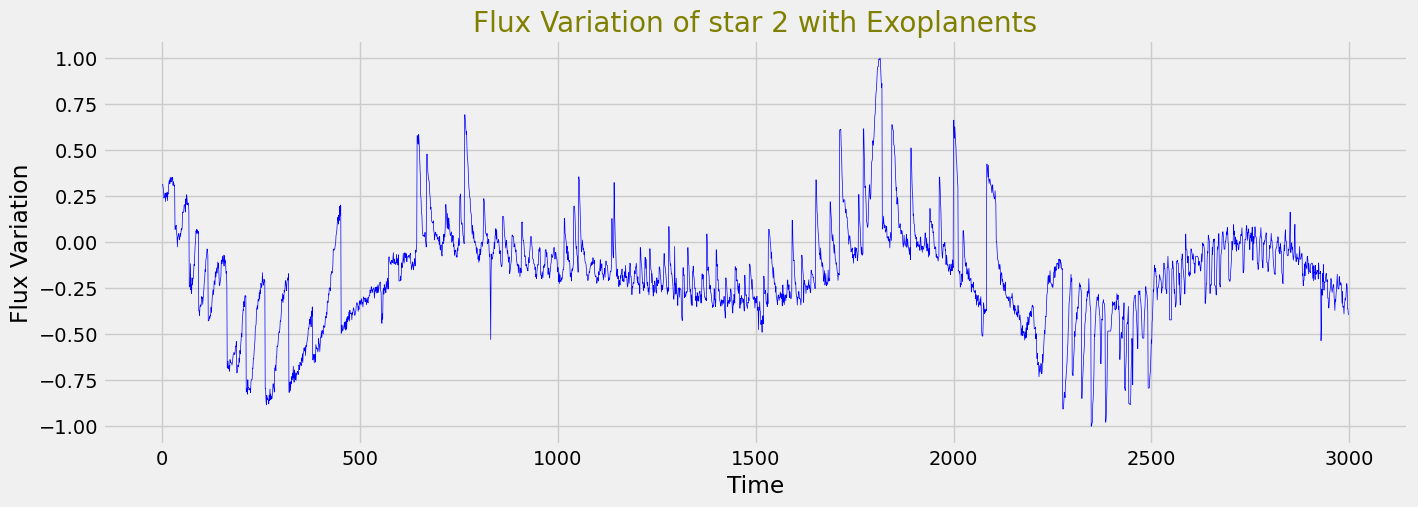

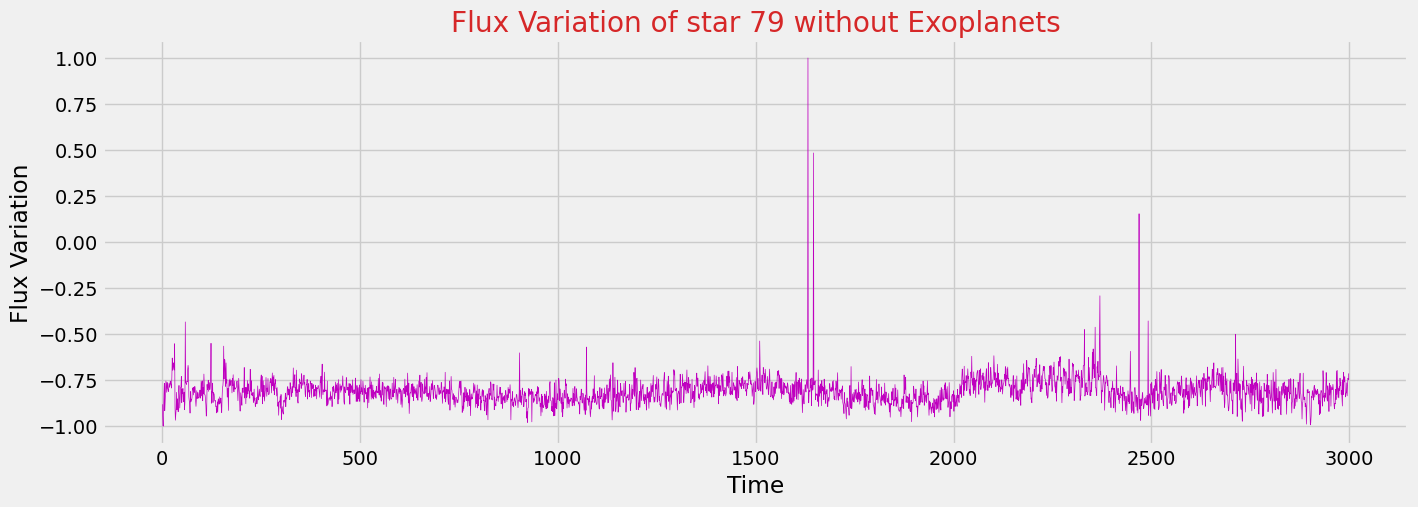

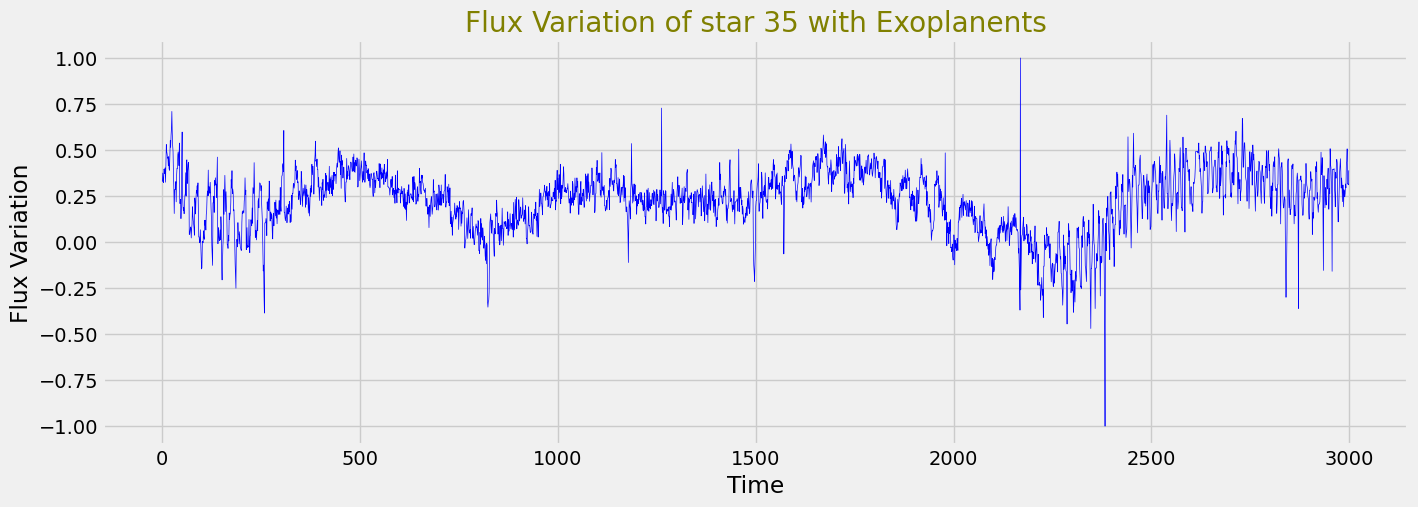

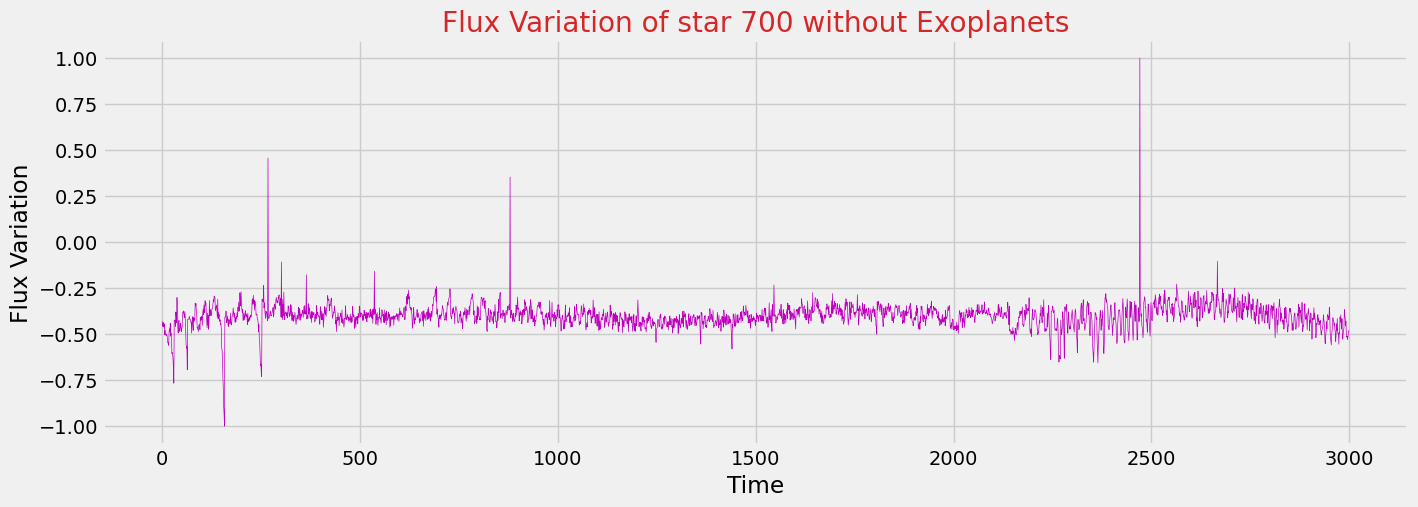

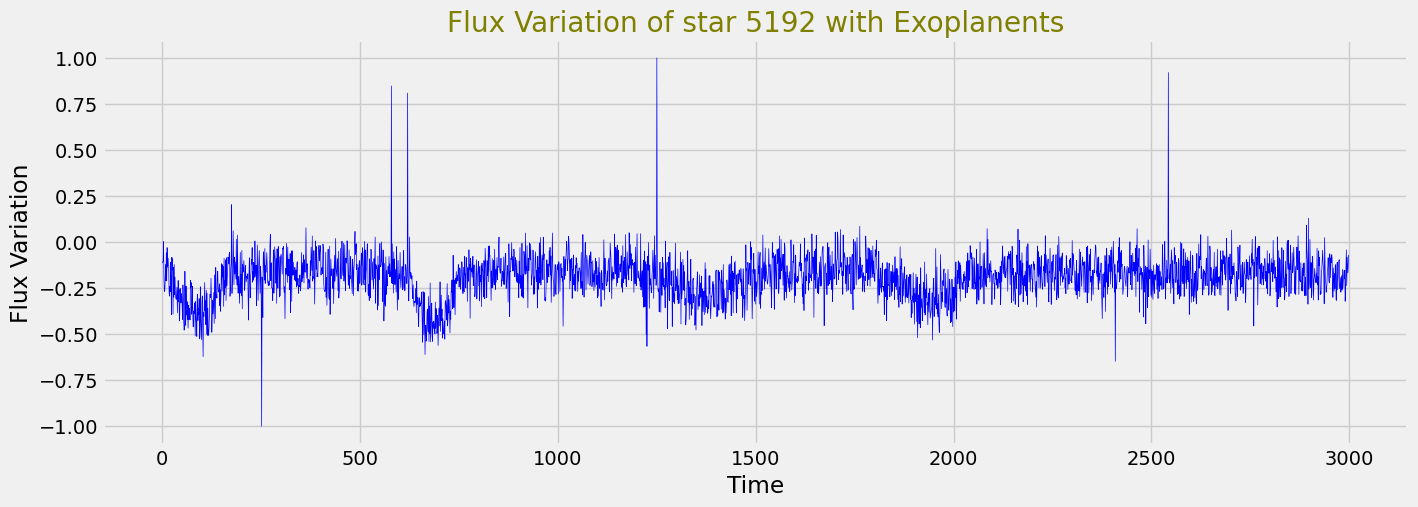

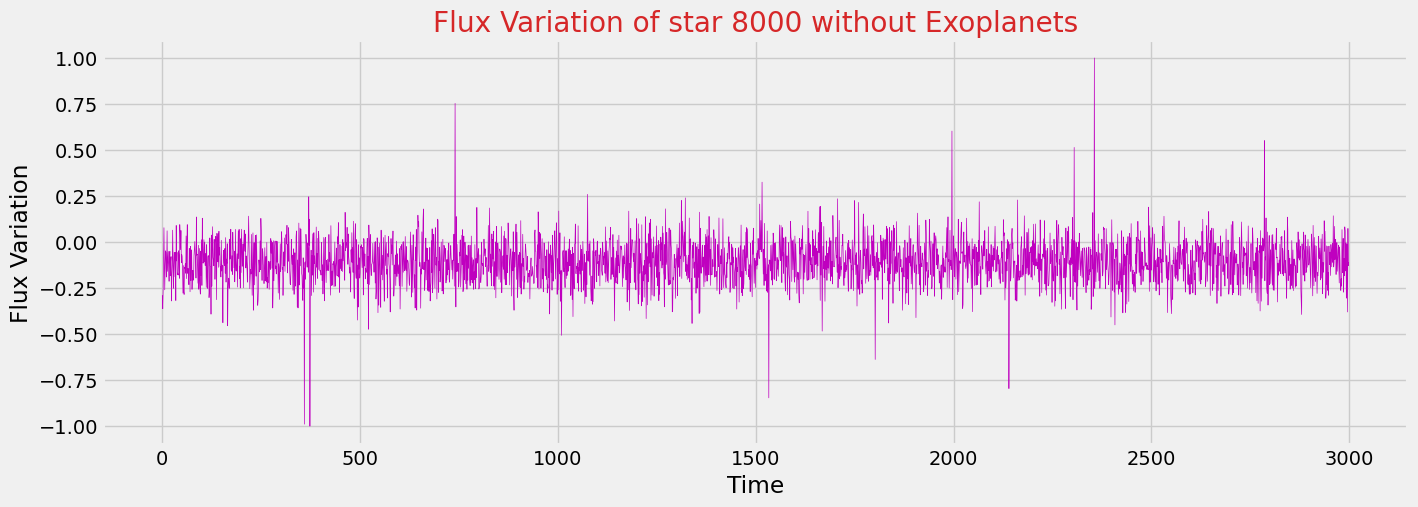

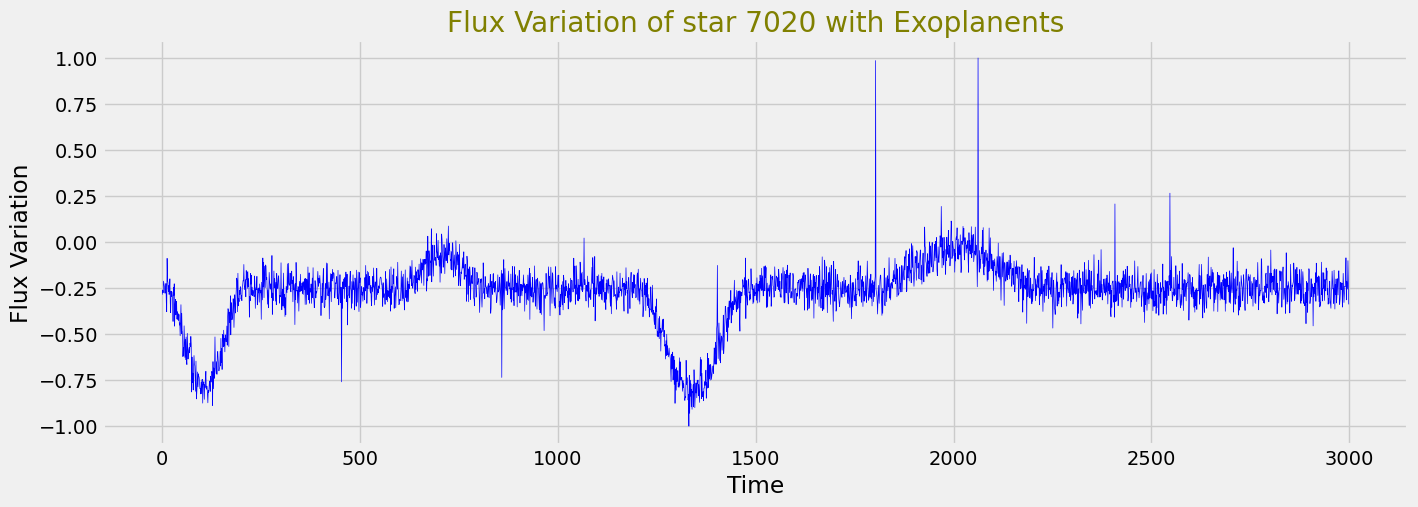

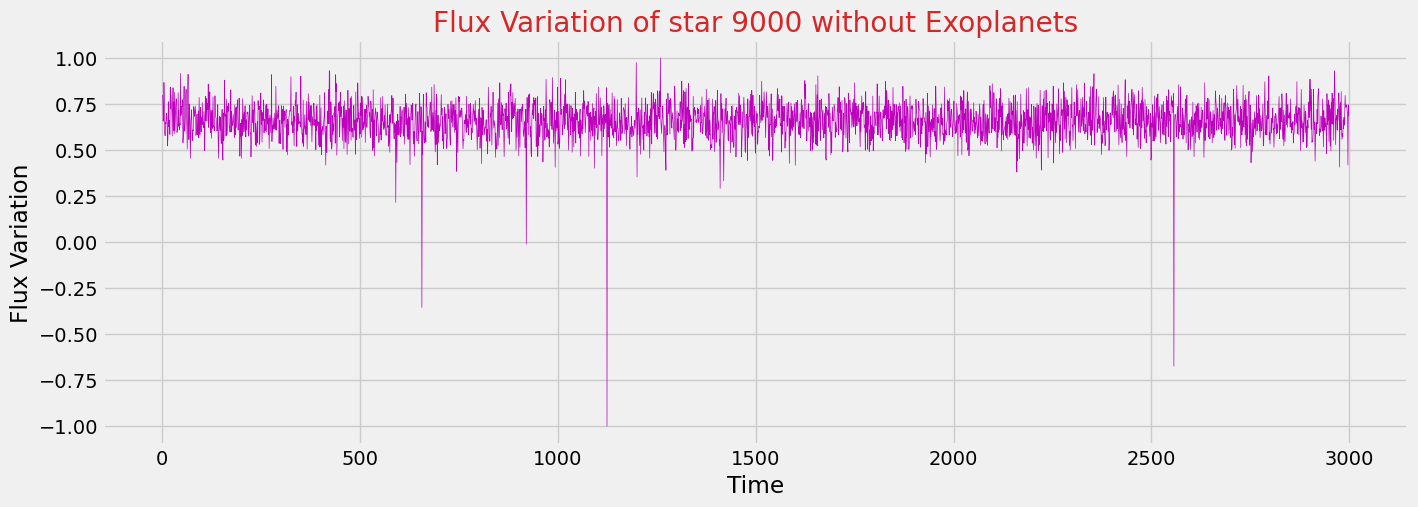

In [86]:
exo, n_exo = [2, 35,5192, 7020], [79, 700, 8000, 9000]

for candidate in range(len(exo)):
    flux_plot(samp, exo[candidate], exo = True)
    flux_plot(samp, n_exo[candidate], exo = False)

# Perform data augmentation manually 

I have tried augmenting with applying RandomOverSampler from imblearn.over_sampling, but this seems to over fit the data and reaches ROC curve 1. So, I've manually augmented the data to add gaussian noise, flipping the flux values, scaling the data and shifting time

In [31]:
def add_gaussian_noise(data, noise_level=0.007):#add more random gaussian noise to entire dataset
    noise = np.random.normal(loc=0.0, scale=noise_level, size=data.shape)
    return data + noise
def scale_data(data, scale_factor_range=(0.9, 1.1)): #scales the data randomly
    factors = np.random.uniform(scale_factor_range[0], scale_factor_range[1], size=(data.shape[0], 1))
    return data * factors
def time_shift_data(data, shift_max): #shifts the data randomly
    data_shifted = np.zeros_like(data)
    for i in range(data.shape[0]):
        shift = np.random.randint(-shift_max, shift_max)
        data_shifted[i] = np.roll(data[i], shift)
    return data_shifted
def flip_data(data): #flips the data
    return np.flip(data, axis=1)

In [32]:
features = combined_data.iloc[:, :-1]  # Exclude the label column
labels = combined_data['Label']  # Just the label column
# Assuming augmentation functions are defined: 
# add_gaussian_noise, scale_data, time_shift_data, flip_data
# These functions should only apply to the feature columns
features_noisy = add_gaussian_noise(features.values)
features_scaled = scale_data(features.values)
features_shifted = time_shift_data(features.values, shift_max=4)
#features_flipped = flip_data(features.values)
# Now, let's create a DataFrame for each augmented set and preserve labels same as the label for original datapoint
df_noisy = pd.DataFrame(features_noisy, columns=features.columns)
df_noisy['Label'] = labels.values  # Preserve original labels

df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['Label'] = labels.values  # Preserve original labels

df_shifted = pd.DataFrame(features_shifted, columns=features.columns)
df_shifted['Label'] = labels.values  # Preserve original labels

#df_flipped = pd.DataFrame(features_flipped, columns=features.columns)
#df_flipped['Label'] = labels.values  # Preserve original labels
# Combine the original and augmented dataframes
df_augmented = pd.concat([combined_data, df_noisy, df_scaled, df_shifted], ignore_index=True)

# `df_augmented` now contains the original data and its augmented versions,
# with each set correctly associated with its original label


In [33]:
df_augmented #augmented dataset

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,Label
0,0.473047,0.460162,0.378400,0.317980,0.301836,0.192559,0.179123,0.229057,0.250079,0.147052,...,-0.035337,0.124311,0.379555,0.412909,0.470660,0.635210,0.635210,0.416977,0.262874,1
1,0.065506,0.081694,0.002484,0.061627,-0.064096,-0.043259,-0.087304,-0.083393,-0.079034,-0.045087,...,0.286500,0.281403,0.230498,0.319229,0.246205,0.357568,0.357568,0.294898,0.176291,1
2,0.309666,0.312718,0.292072,0.276431,0.238777,0.247662,0.246267,0.266634,0.220270,0.264773,...,-0.315221,-0.292872,-0.253347,-0.225183,-0.243420,-0.362124,-0.362124,-0.392651,-0.395015,1
3,0.862940,0.928292,0.787255,0.774041,0.835447,0.819665,0.849820,0.815312,0.818788,0.852951,...,-0.016502,0.029748,0.058149,0.077376,0.067262,0.154564,0.154564,-0.056396,-0.138938,1
4,-0.486623,-0.490560,-0.495214,-0.477761,-0.450283,-0.433401,-0.406955,-0.424788,-0.400537,-0.386860,...,0.071575,0.100268,0.111201,0.135671,0.176343,-0.168813,-0.168813,-0.123787,-0.109254,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40035,-0.338892,-0.391740,-0.455210,-0.375756,-0.349889,-0.407798,-0.406070,-0.265920,-0.371079,-0.270377,...,-0.564816,-0.314212,-0.548663,-0.492470,-0.385907,-0.206605,-0.290167,-0.396817,-0.368305,0
40036,-0.449420,-0.446536,-0.357271,-0.412749,-0.400387,-0.280158,-0.349111,-0.294548,-0.245126,-0.485763,...,-0.409708,-0.539474,-0.406393,-0.264351,-0.289308,-0.395079,-0.298781,-0.442155,-0.508779,0
40037,-0.455969,-0.443357,-0.302601,-0.361672,-0.301779,-0.370098,-0.341202,-0.393452,-0.296154,-0.283831,...,-0.409413,-0.405872,-0.389213,-0.255045,-0.332459,-0.369360,-0.338089,-0.358648,-0.241660,0
40038,0.002573,-0.046474,0.079447,-0.067834,0.191559,-0.025381,0.071607,0.067027,-0.006372,-0.041424,...,0.021113,0.064411,-0.070371,0.083268,0.191800,0.017034,0.124587,-0.100251,0.069111,0


In [34]:
idx_lab2 = list(df_augmented[df_augmented['Label'] == 1].index)
print(f"Index list for label 1 star in the data:-\n{idx_lab2}\n")

Index list for label 1 star in the data:-
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 5123, 5192, 5298, 5530, 5557, 5818, 5920, 6782, 7020, 7682, 7827, 7858, 8104, 8183, 8200, 8583, 8695, 8697, 8743, 8857, 9109, 9463, 9536, 9543, 9653, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 15133, 15202, 15308, 15540, 15567, 15828, 15930, 16792, 17030, 17692, 17837, 17868, 18114, 18193, 18210, 18593, 18705, 18707, 18753, 18867, 19119, 19473, 19546, 19553, 19663, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20027, 20028, 20029, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048, 20049, 20050, 20051, 20052, 20053, 20054, 2

In [87]:
# Extract dependent and independent features
x =df_augmented.drop(['Label'], axis = 1)
y = df_augmented.Label

print(f"Take a look over ~\n\nX train array:-\n{x.values}\n\nY train array:-\n{y.values}")

Take a look over ~

X train array:-
[[ 0.47304659  0.46016183  0.37840006 ...  0.63520979  0.41697734
   0.26287353]
 [ 0.06550624  0.08169448  0.00248433 ...  0.3575676   0.2948983
   0.17629145]
 [ 0.30966625  0.31271807  0.29207179 ... -0.36212399 -0.39265145
  -0.39501475]
 ...
 [-0.45596899 -0.44335671 -0.30260083 ... -0.33808943 -0.35864791
  -0.2416596 ]
 [ 0.00257329 -0.0464739   0.07944719 ...  0.124587   -0.10025121
   0.0691112 ]
 [-0.31344552 -0.10416261  0.05082033 ... -0.17095603 -0.10628225
  -0.08504669]]

Y train array:-
[1 1 1 ... 0 0 0]


In [88]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
#divide the dataset into text and test data with test data being 30% of the dataset

In [89]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Checking the minimum, mean and maxmum value after scaling
print("X_train after scaling ~\n")
print(f"Minimum:- {round(np.min(X_train_sc),2)}\nMean:- {round(np.mean(X_train_sc),2)}\nMax:- {round(np.max(X_train_sc), 2)}\n")
print("--------------------------------\n")
print("X_test after scaling ~\n")
print(f"Minimum:- {round(np.min(X_test_sc),2)}\nMean:- {round(np.mean(X_test_sc),2)}\nMax:- {round(np.max(X_test_sc), 2)}\n")

X_train after scaling ~

Minimum:- -2.33
Mean:- -0.0
Max:- 3.14

--------------------------------

X_test after scaling ~

Minimum:- -2.31
Mean:- -0.01
Max:- 3.14



In [90]:
def optimal_Kval_KNN(start_k, end_k, x_train, x_test, y_train, y_test, progress = True):
    ''' 
    This function takes in the following arguments -
    start_k - start value of k
    end_k - end value of k
    x_train - independent training values for training the KNN
    x_test - independent testing values for prediction
    y_train - dependent training values for training KNN
    y_test - dependent testing values for computing error rate
    progress - if true shows the progress for each k (by default its set to True)
    '''
    # Header
    print(f"Fetching the optimal value of K in between {start_k} & {end_k} ~\n\nIn progress...")
    
    # Empty list to append error rate
    mean_err = []
    for K in range(start_k, end_k + 1):                         # Generates K from start to end-1 values
        knn = KNC(n_neighbors = K)                              # Build KNN for respective K value
        knn.fit(x_train, y_train)                               # Train the model
        err_rate = np.mean(knn.predict(x_test) != y_test)       # Get the error rate
        mean_err.append(err_rate)                               # Append it
        # If progress is true display the error rate for each K
        if progress == True:print(f'For K = {K}, mean error = {err_rate:.3}')
        
    # Get the optimal value of k and corresponding value of mean error
    k, val = mean_err.index(min(mean_err))+1, min(mean_err)
    
    # Footer
    print('\nDone! Here is how error rate varies wrt to K values:- \n')
    
    # Display how error rate changes wrt K values and mark the optimal K value
    plt.figure(figsize = (5,5))
    plt.plot(range(start_k,end_k + 1), mean_err, 'mo--', markersize = 8, markerfacecolor = 'c',
            linewidth = 1)          # plots all mean error wrt K values
    plt.plot(k, val, marker = 'o', markersize = 8, markerfacecolor = 'gold', 
             markeredgecolor = 'g') # highlits the optimal K
    plt.title(f"The optimal performance is obtained at K = {k}", color = 'r', weight = 'bold',
             fontsize = 15)
    plt.ylabel("Error Rate", color = 'olive', fontsize = 13)
    plt.xlabel("K values", color = 'olive', fontsize = 13)
    
    '''returns the optimal value of k'''
    return k

Fetching the optimal value of K in between 1 & 10 ~

In progress...
For K = 1, mean error = 8.33e-05
For K = 2, mean error = 0.00108
For K = 3, mean error = 0.00133
For K = 4, mean error = 0.003
For K = 5, mean error = 0.00333
For K = 6, mean error = 0.00491
For K = 7, mean error = 0.00516
For K = 8, mean error = 0.00508
For K = 9, mean error = 0.00516
For K = 10, mean error = 0.00516

Done! Here is how error rate varies wrt to K values:- 



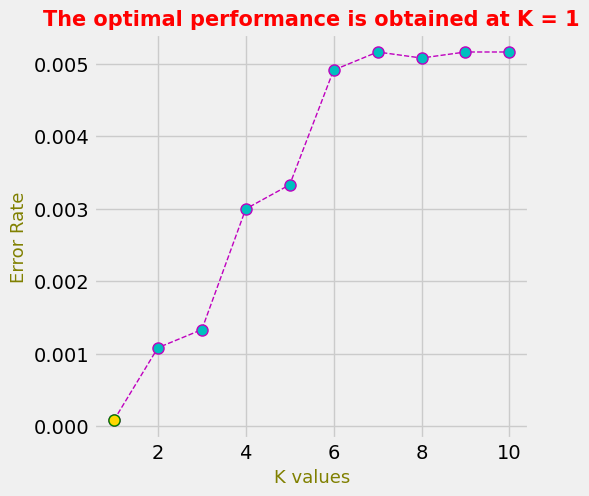

In [39]:
k = optimal_Kval_KNN(1, 10, X_train_sc, X_test_sc, y_train, y_test)


Validation accuracy of KNN is 0.99991674991675

-------------------------------------------------------

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11939
           1       1.00      0.99      0.99        73

    accuracy                           1.00     12012
   macro avg       1.00      0.99      1.00     12012
weighted avg       1.00      1.00      1.00     12012



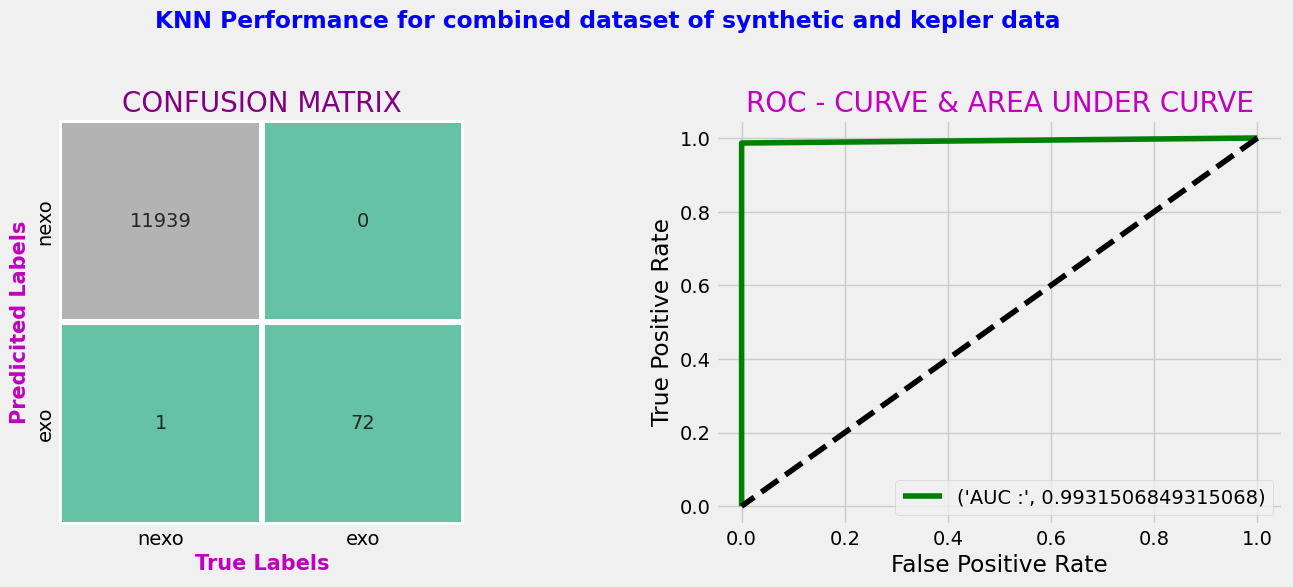

In [91]:
knn_classifier = KNC(n_neighbors=1,metric='minkowski',p=2)  
'''metric is to be by default minkowski for p = 2 to calculate the Eucledian distances'''
# Fit the model
knn_classifier.fit(X_train_sc, y_train)
# Predict
y_pred = knn_classifier.predict(X_test_sc)
# Results
print('\nValidation accuracy of KNN is', accuracy_score(y_test,y_pred))
print("\n-------------------------------------------------------")
print ("\nClassification report :\n",(classification_report(y_test,y_pred)))
#Confusion matrix
plt.figure(figsize=(15,11))
plt.subplots_adjust(wspace = 0.3)
plt.suptitle("KNN Performance for combined dataset of synthetic and kepler data", color = 'b', weight = 'bold')
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')
#ROC curve and Area under the curve plotting
predicting_probabilites = knn_classifier.predict_proba(X_test_sc)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "g")
plt.plot([1,0],[1,0], 'k--')
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20, color = 'm')
plt.show()

KNN performs really good here. So, let's if any other feasible Machine learning model can be found for dataset classification 

# Let's try other models

In [45]:
#Decision tree classifier
DTClassifier=DecisionTreeClassifier(criterion='entropy', random_state=0)
DTClassifier.fit(X_train,y_train)
y_pred = DTClassifier.predict(X_test)
print('The accuracy of decision tree is: ', metrics.accuracy_score(y_pred,y_test))


The accuracy of decision tree is:  0.9960872460872461


Text(0.5, 1.0, 'CONFUSION MATRIX')

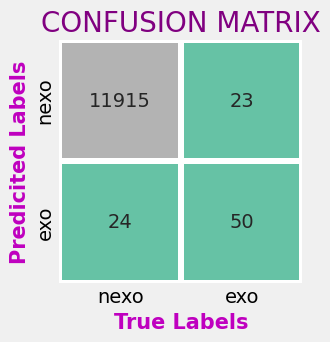

In [46]:
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_pred, y_test),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')

The accuracy of Naive baise is:  0.9547952047952047


Text(0.5, 1.0, 'CONFUSION MATRIX')

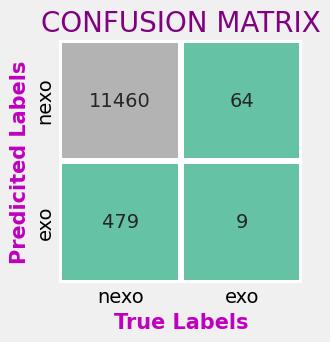

In [41]:
#Naive Bayes classifier
NBClassifier=GaussianNB()
NBClassifier.fit(X_train_sc, y_train.ravel())
y_pred1 = NBClassifier.predict(X_test)
print('The accuracy of Naive baise is: ', metrics.accuracy_score(y_pred1, y_test))
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_pred1, y_test),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')

The accuracy of Logistic Regression is:  0.9985847485847485


Text(0.5, 1.0, 'CONFUSION MATRIX')

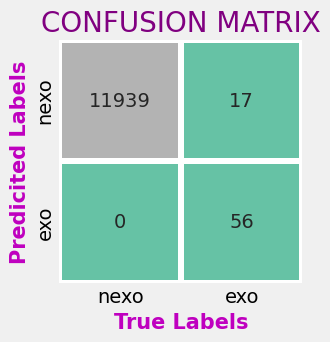

In [42]:
#Logistic Regression
logistic1 = LogisticRegression()
logistic1.fit(X_train,y_train.ravel())
predict1 = logistic1.predict(X_test)
print('The accuracy of Logistic Regression is: ', metrics.accuracy_score(predict1,y_test))
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(predict1, y_test),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')

The accuracy of Random Forest Classifier is:  0.9975024975024975


Text(0.5, 1.0, 'CONFUSION MATRIX')

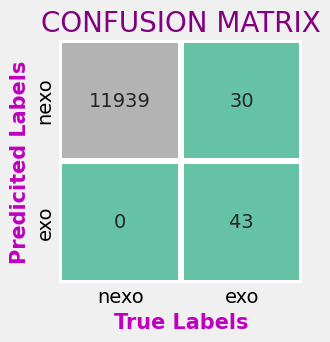

In [43]:
# RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=25)
model.fit(X_train, y_train.ravel())
prediction = model.predict(X_test)
prediction
print('The accuracy of Random Forest Classifier is: ', metrics.accuracy_score(prediction,y_test))
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(prediction, y_test),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')

The accuracy of Support Vector Classifier is:  0.9956709956709957


Text(0.5, 1.0, 'CONFUSION MATRIX')

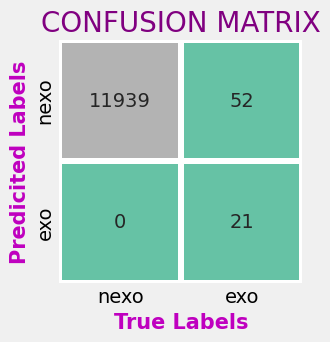

In [44]:
#Support Vector classification -Linear
classifier = SVC(kernel ='linear', gamma='auto', C=2)
classifier = SVC(probability=True)
classifier.fit(X_train, y_train.ravel())
y_predict = classifier.predict(X_test)
print('The accuracy of Support Vector Classifier is: ', metrics.accuracy_score(y_predict,y_test))
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_predict, y_test),annot=True,cmap="Set2",fmt = "d",linewidths=3, cbar = False,
           xticklabels=['nexo', 'exo'], yticklabels=['nexo','exo'], square = True)
plt.xlabel("True Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.ylabel("Predicited Labels", fontsize = 15, weight = 'bold', color = 'm')
plt.title("CONFUSION MATRIX",fontsize=20, color = 'purple')

In [47]:
r_prob = [0 for _ in range(len(y_test))]
rf_prob = model.predict_proba(X_test)
nb_prob = NBClassifier.predict_proba(X_test)
dt_prob = DTClassifier.predict_proba(X_test)
log_prob = logistic1.predict_proba(X_test)
svm_prob = classifier.predict_proba(X_test)
rf_prob = rf_prob[:,1]
nb_prob = nb_prob[:,1]
dt_prob = dt_prob[:,1]
log_prob = log_prob[:,1]
svm_prob = svm_prob[:,1]
r_auc = roc_auc_score(y_test, r_prob)
rf_auc = roc_auc_score(y_test, rf_prob)
nb_auc = roc_auc_score(y_test, nb_prob)
dt_auc = roc_auc_score(y_test, dt_prob)
log_auc = roc_auc_score(y_test, log_prob)
svm_auc = roc_auc_score(y_test, svm_prob)
r_fpr, r_tpr, _ = roc_curve(y_test, r_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)
log_fpr, log_tpr, _ = roc_curve(y_test, log_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)


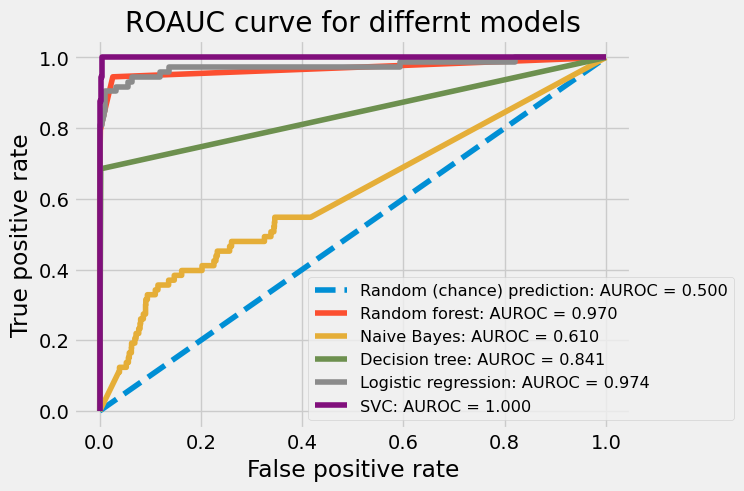

In [54]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random (chance) prediction: AUROC = %.3f' % (r_auc))
plt.plot(rf_fpr, rf_tpr, label='Random forest: AUROC = %.3f' % (rf_auc))
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes: AUROC = %.3f' % (nb_auc))
plt.plot(dt_fpr, dt_tpr,  label='Decision tree: AUROC = %.3f' % (dt_auc))
plt.plot(log_fpr, log_tpr,  label='Logistic regression: AUROC = %.3f' % (log_auc))
plt.plot(svm_fpr, svm_tpr, label='SVC: AUROC = %.3f' % (svm_auc))
plt.title('ROAUC curve for differnt models')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0), fontsize='small')